In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd

#import src.utils.preprocess as pre
import preprocess as pre
from tst import Transformer, Transformer_Sigmoid
# from tst import Transformer_with_sst
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.neural_network import MLPRegressor
import torch

In [3]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [4]:
import random
random.seed(20)
torch.manual_seed(422) #423
np.random.seed(10)


In [5]:
plt.rcParams.update({'font.size': 14})

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)

In [7]:
device

device(type='cuda')

# Download data

In [8]:
%%time
(X_train, y_train), (X_test, y_test) = pre.create_dataset(n_comp=20,n_sst_comp=20,target_variable='tmp2m')

CPU times: user 3 s, sys: 9.37 s, total: 12.4 s
Wall time: 12.5 s


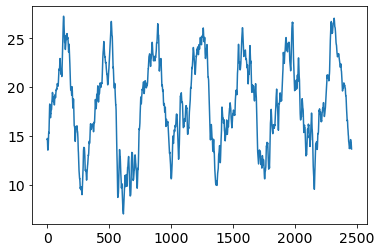

In [9]:
plt.plot(y_test[:, 509])

In [10]:
# choose one location
y_train = y_train[:,509].reshape((-1,1))
y_test = y_test[:,509].reshape((-1,1))

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9934, 40), (2456, 40), (9934, 1), (2456, 1))

In [12]:
# normilize X
X_mins = np.amin(X_train,axis=0)
# y_min = np.amin(y_train,axis=0)
X_train = X_train - X_mins
X_test = X_test - X_mins
# y_train = y_train - y_min
# y_test = y_test - y_min
X_maxs = np.amax(X_train,axis=0)
# y_max = np.amax(y_train,axis=0)
X_train = X_train/X_maxs
X_test = X_test/X_maxs
# y_train = y_train/y_max
# y_test = y_test/y_max

In [13]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, -0.08301995004894765, 1.0356012691558016)

# Detrending and Retrending functions

In [14]:
def detrend(y_train, y_test):
    train_dates = pd.date_range(start='1/1/1985', periods=y_train.shape[0])
    test_dates = pd.date_range(start=train_dates[-1] + pd.DateOffset(1), periods= y_test.shape[0])

    df_y_train = pd.DataFrame(y_train, index=train_dates)
    df_y_test = pd.DataFrame(y_test, index=test_dates)
    df_y_test.index = [df_y_test.index.month.astype(str)+"-"+df_y_test.index.day.astype(str),df_y_test.index]

    training_day_month_combos = df_y_train.index.month.astype(str)+"-"+df_y_train.index.day.astype(str)

    df_y_test = df_y_test.sub(df_y_train.groupby(training_day_month_combos).mean(),level=0)
    df_y_train = df_y_train.sub(df_y_train.groupby([df_y_train.index.month,df_y_train.index.day]).transform('mean'))
    
    df_y_test = df_y_test.div(df_y_train.groupby(training_day_month_combos).std(),level=0)
    df_y_train = df_y_train.div(df_y_train.groupby([df_y_train.index.month,df_y_train.index.day]).transform('std'))

    df_y_test = df_y_test.reset_index(level=0, drop=True)

    y_train_detrend = df_y_train.to_numpy()
    y_test_detrend = df_y_test.to_numpy()
    
    return y_train_detrend, y_test_detrend

In [15]:
def retrend(y_train_detrend, y_test_detrend, orig_y_train):
    train_dates = pd.date_range(start='1/1/1985', periods=y_train_detrend.shape[0])
    test_dates = pd.date_range(start=train_dates[-1] + pd.DateOffset(1), periods= y_test_detrend.shape[0])

    df_y_train = pd.DataFrame(y_train_detrend, index=train_dates)
    df_y_orig = pd.DataFrame(orig_y_train, index=train_dates)
    df_y_test = pd.DataFrame(y_test_detrend, index=test_dates)
    df_y_test.index = [df_y_test.index.month.astype(str)+"-"+df_y_test.index.day.astype(str),df_y_test.index]

    training_day_month_combos = df_y_train.index.month.astype(str)+"-"+df_y_train.index.day.astype(str)

    df_y_test = df_y_test.mul(df_y_orig.groupby(training_day_month_combos).std(),level=0)
    df_y_train = df_y_train.mul(df_y_orig.groupby([df_y_train.index.month,df_y_train.index.day]).transform('std'))

    df_y_test = df_y_test.add(df_y_orig.groupby(training_day_month_combos).mean(),level=0)
    df_y_train = df_y_train.add(df_y_orig.groupby([df_y_train.index.month,df_y_train.index.day]).transform('mean'))
    
    df_y_test = df_y_test.reset_index(level=0, drop=True)

    y_train_retrend = df_y_train.to_numpy()
    y_test_retrend = df_y_test.to_numpy()
    
    return y_train_retrend, y_test_retrend

# Proof my detrending code works

In [16]:
y_train_detrend, y_test_detrend = detrend(y_train, y_test)

In [17]:
y_train_detrend.shape, y_test_detrend.shape

((9934, 1), (2456, 1))

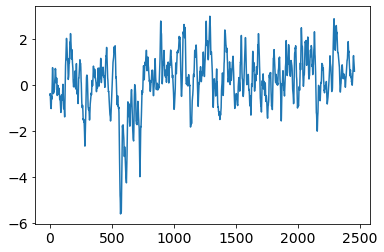

In [18]:
plt.plot(y_test_detrend)

Confirming that the applying the detrend function then the retrend function brings you back to the original.

In [19]:
(retrend(y_train_detrend, y_test_detrend, y_train)[0] - y_train).max()

3.552713678800501e-15

In [20]:
np.allclose(y_test, retrend(y_train_detrend, y_test_detrend, y_train)[1])

True

In [21]:
np.allclose(y_train, retrend(y_train_detrend, y_test_detrend, y_train)[0])

True

In [22]:
# normilize detrended data
y_min = np.amin(y_train_detrend, axis=0)
y_train_detrend = y_train_detrend - y_min
y_test_detrend = y_test_detrend - y_min

y_max = np.amax(y_train_detrend,axis=0)
y_train_detrend = y_train_detrend/y_max
y_test_detrend = y_test_detrend/y_max

In [23]:
print(np.max(y_train_detrend), np.min(y_train_detrend), np.max(y_test_detrend), np.min(y_test_detrend))

1.0 0.0 1.0120511795379619 -0.2382153668340343


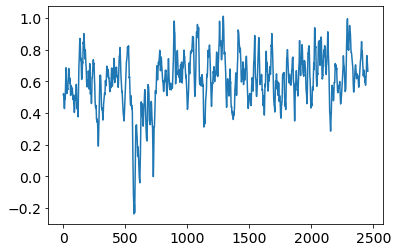

In [24]:
plt.plot(y_test_detrend)

In [25]:
# concatenate data to shift it for Transformer
X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train_detrend, y_test_detrend), axis=0)

data_total = np.concatenate((X_total[28:], y_total[:-28]), axis=1)

In [26]:
y_total_with_trend = np.concatenate((y_train, y_test), axis=0)

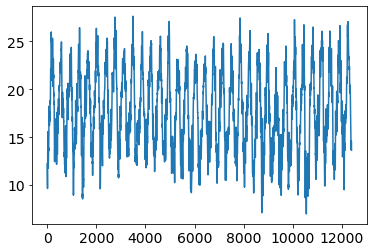

In [27]:
plt.plot(y_total_with_trend)

In [28]:
train_range = int(0.8*data_total.shape[0])
train_data_array = data_total[0:train_range]
test_data_array = data_total[train_range:]

In [29]:
train_data = torch.FloatTensor(train_data_array)
test_data = torch.FloatTensor(test_data_array)
# y_train = torch.FloatTensor(y_train_detrend)

### Transformer model 

In [30]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
#         train_label = input_data[i+train_window-1,feature_size-1] # get y_t+14
        train_label = input_data[i+train_window+pred_window-1,feature_size-1]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [31]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 41
train_seq, train_label torch.Size([90, 41]) torch.Size([])


In [32]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [50]:
BATCH_SIZE = 256
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [51]:
train_window = 90
pred_window = 28
test_seq = create_sequence(test_data, train_window, pred_window)

dataset_test = SeqDataset(test_seq)
dataloader_test = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

feature_size 41
train_seq, train_label torch.Size([90, 41]) torch.Size([])


In [52]:
d_input = 41 # From dataset
d_output = 1 # From dataset

attention_size = 90 #8 for old
LR = 1e-5 #1e-3
d_model = 64
q = 8 # Query size 8 for old
v = 8 # Value size 8 for old
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer_Sigmoid(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=14, seq_length=90).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=1e-5)
loss_function = nn.MSELoss()

In [53]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

2319132

In [ ]:
# train of OLD (small) Transformer, you can cut/skip it
EPOCHS = 100
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout) #myLoss(y_label.to(device), netout)
            #loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
        
#         with torch.no_grad():
#             net.eval()
#             loss_val = 0
#             for idx_batch, (x, y_label) in enumerate(dataloader_test):
#                 y_label = y_label.view(-1,1)

#                 netout = net(x.to(device))
#                 loss_val += loss_function(y_label.to(device), netout).item()

#         hist_loss_val[idx_epoch] = loss_val / (idx_batch+1)
        pbar.set_postfix({'loss': hist_loss[idx_epoch]})
#         pbar.set_postfix({'loss': hist_loss[idx_epoch], 'val_loss': hist_loss_val[idx_epoch]})
#         net.train()
            
        
plt.plot(hist_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('loss value')
# plt.plot(hist_loss_val, label='test')
# plt.xlabel('epoch')
# plt.ylabel('loss value')
plt.legend()

[Epoch  81/100]: 100%|██████████| 9771/9771 [00:11<00:00, 824.81it/s, loss=0.0117, val_loss=0.0116] 


[Epoch 100/100]: 100%|██████████| 9771/9771 [00:11<00:00, 832.53it/s, loss=0.0103, val_loss=0.0107] 


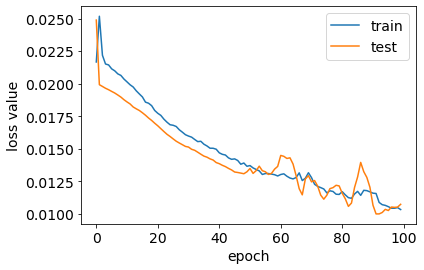

In [54]:
EPOCHS = 100
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout) #myLoss(y_label.to(device), netout)
            #loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
        
        with torch.no_grad():
            net.eval()
            loss_val = 0
            for idx_batch, (x, y_label) in enumerate(dataloader_test):
                y_label = y_label.view(-1,1)

                netout = net(x.to(device))
                loss_val += loss_function(y_label.to(device), netout).item()

        hist_loss_val[idx_epoch] = loss_val / (idx_batch+1)
        pbar.set_postfix({'loss': hist_loss[idx_epoch], 'val_loss': hist_loss_val[idx_epoch]})
        net.train()
            
        
plt.plot(hist_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(hist_loss_val, label='test')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

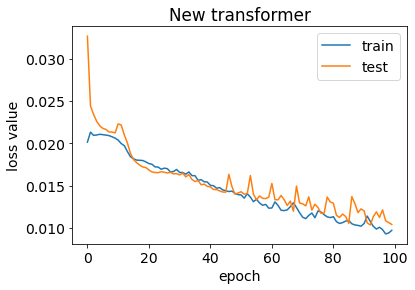

In [70]:
plt.plot(hist_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.plot(hist_loss_val, label='test')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title('New transformer')
plt.legend()

In [55]:
train_test_total = np.concatenate((train_data_array, test_data_array))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12272/12272 [04:14<00:00, 48.14it/s]


In [56]:
y_all = np.concatenate((y_train_detrend, y_test_detrend))[:-28] # detrended version, normilized
print(y_all.shape)

(12362, 1)


In [57]:
y_all_with_trend = np.concatenate((y_train, y_test))[:-28] # a version with trend, no normalization
print(y_all_with_trend.shape)

(12362, 1)


In [58]:
test_size = y_test.shape[0]
target = 'tmp'

r-sq on train: 0.1814549294917992
r-sq on test: -0.136619611632409
cosine_similarity on train: [[0.97779429]]
cosine_similarity on test: [[0.95722102]]


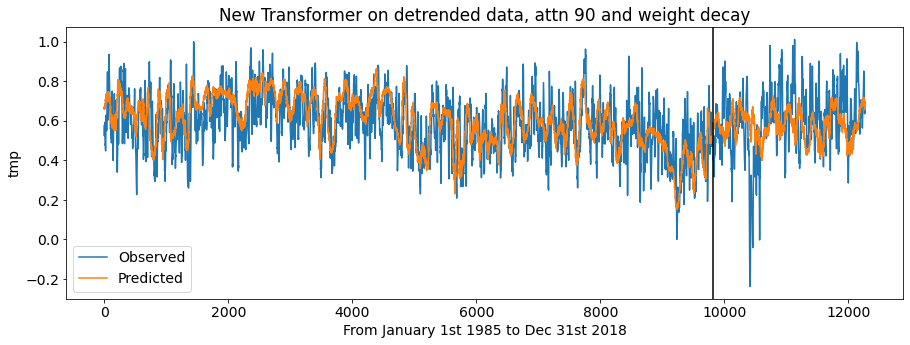

In [59]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), 
                                                       res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  
                                                      res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer on detrended data, attn 90 and weight decay')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: -0.19195200186314887
r-sq on test: -0.2654081766255809
cosine_similarity on train: [[0.96544073]]
cosine_similarity on test: [[0.95692033]]


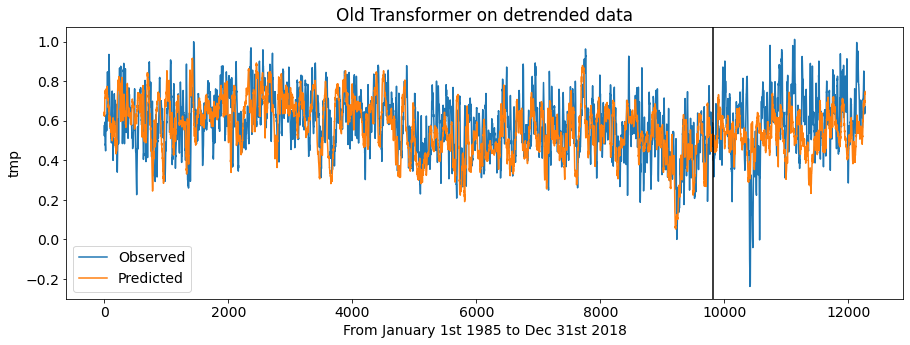

In [42]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), 
                                                       res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  
                                                      res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Old Transformer on detrended data')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.09926583925239918
r-sq on test: -0.19926882604690666
cosine_similarity on train: [[0.97496903]]
cosine_similarity on test: [[0.95711319]]


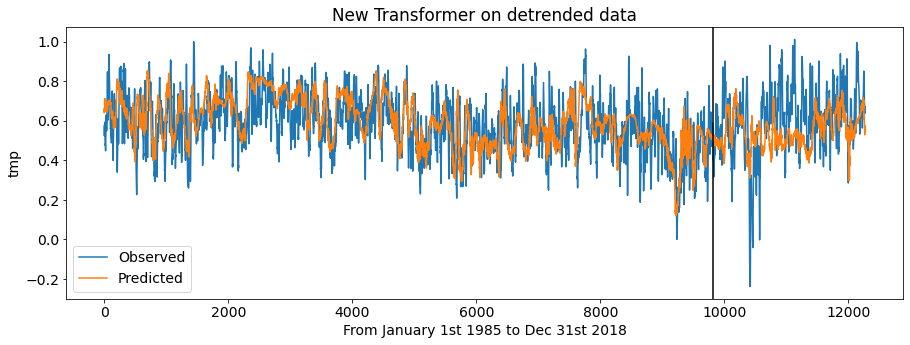

In [44]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), 
                                                       res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  
                                                      res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer on detrended data')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [45]:
y_all[train_window:-test_size].shape, y_all[-test_size:].shape

((9816, 1), (2456, 1))

In [60]:
# renormilize
res_renorm = res*y_max + y_min

y_all_renorm = y_all*y_max + y_min

r-sq on train: -0.19195200186314887
r-sq on test: -0.26540817662558136
cosine_similarity on train: [[0.38790803]]
cosine_similarity on test: [[0.10178785]]


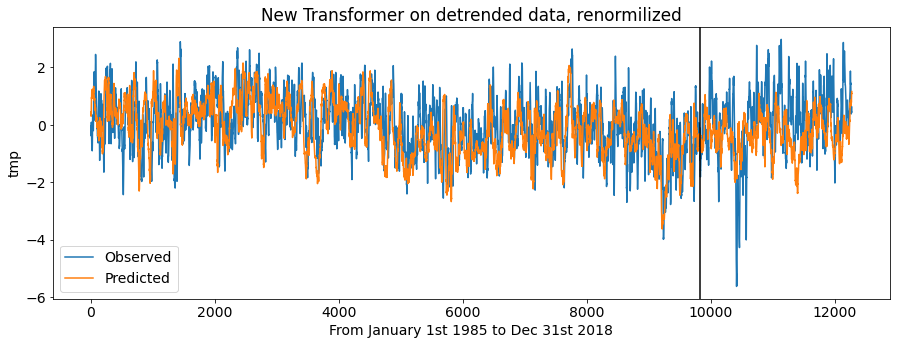

In [44]:
print('r-sq on train:', r2_score(y_all_renorm[train_window:-test_size], res_renorm[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all_renorm[-test_size:],  res_renorm[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all_renorm[train_window:-test_size].reshape((1,-1)), 
                                                       res_renorm[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all_renorm[-test_size:].reshape((1,-1)),  
                                                      res_renorm[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all_renorm[train_window:],label='Observed')
plt.plot(res_renorm[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer on detrended data, renormilized')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.09926583925239929
r-sq on test: -0.19926882604690688
cosine_similarity on train: [[0.48886206]]
cosine_similarity on test: [[0.0859218]]


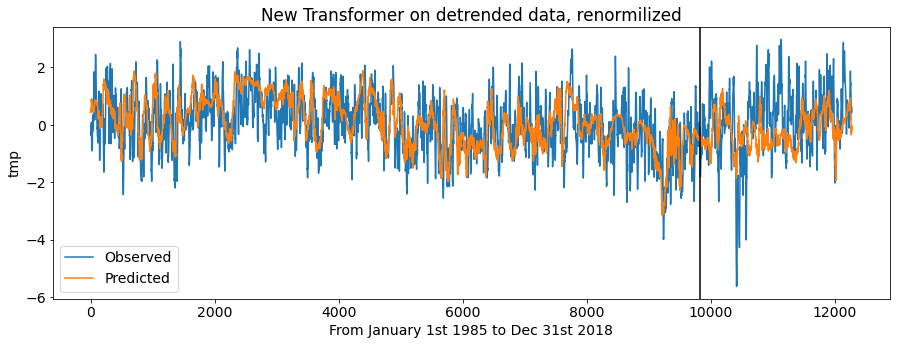

In [47]:
print('r-sq on train:', r2_score(y_all_renorm[train_window:-test_size], res_renorm[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all_renorm[-test_size:],  res_renorm[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all_renorm[train_window:-test_size].reshape((1,-1)), 
                                                       res_renorm[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all_renorm[-test_size:].reshape((1,-1)),  
                                                      res_renorm[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all_renorm[train_window:],label='Observed')
plt.plot(res_renorm[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer on detrended data, renormilized')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [48]:
y_total_with_trend[:-28][train_window:-test_size].shape

(9816, 1)

In [49]:
res_renorm.shape, y_total_with_trend.shape

((12362,), (12390, 1))

In [50]:
a = np.array([1, 2, 3, 4, 5])
a[:-2]

array([1, 2, 3])

In [51]:
res_renorm[:-test_size+28].shape, res_renorm[-test_size:].shape

((9934,), (2456,))

In [52]:
y_total_with_trend[:-28][:-test_size+28].shape

(9934, 1)

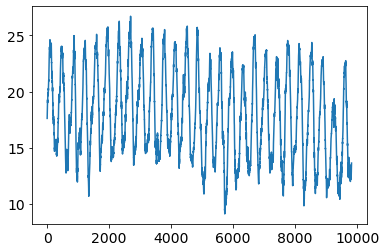

In [61]:
# add trend back
# ? do we need take y_total_with_trend[:-28] since we already took it
y_train_pred_retrend, y_test_pred_retrend = retrend(res_renorm[train_window:-test_size], res_renorm[-test_size:], 
        y_total_with_trend[:-28][train_window:-test_size])

# y_train_pred_retrend, y_test_pred_retrend = retrend(res_renorm[:-test_size+28], res_renorm[-test_size:], 
#         y_total_with_trend[:-28][:-test_size+28])

plt.plot(y_train_pred_retrend)

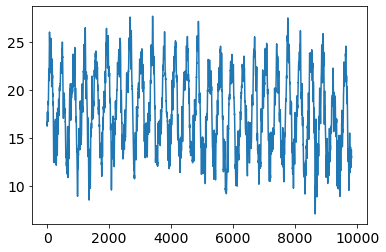

In [62]:
plt.plot(y_total_with_trend[:-28][train_window:-test_size])

In [63]:
y_all_with_trend[train_window:-test_size].shape, y_train_pred_retrend[:-118].shape

((9816, 1), (9698, 1))

r-sq on train: 0.8582269510363381
r-sq on test: 0.7839494371918779


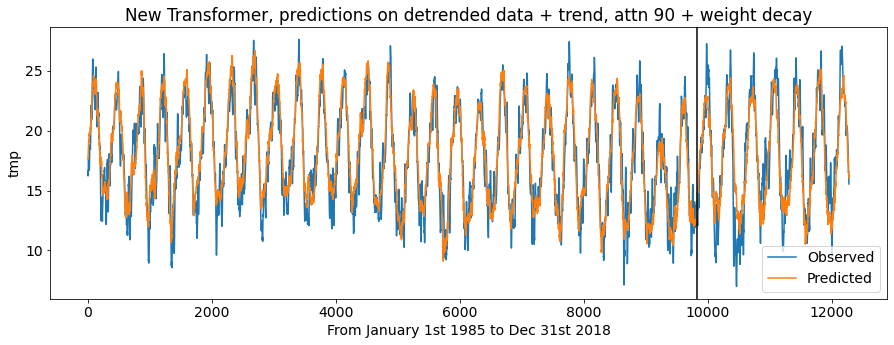

In [64]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_retrend))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_retrend))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer, predictions on detrended data + trend, attn 90 + weight decay')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.8423277817229757
r-sq on test: 0.7701571830488569


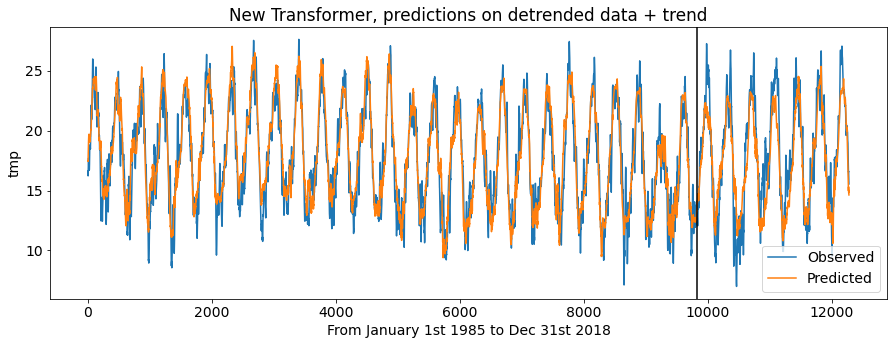

In [56]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_retrend))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_retrend))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer, predictions on detrended data + trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.7951202796264242
r-sq on test: 0.7655938902531022


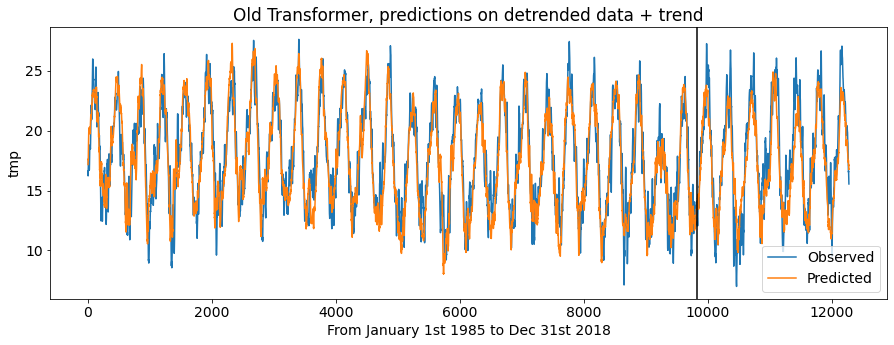

In [48]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_retrend))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_retrend))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Old Transformer, predictions on detrended data + trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

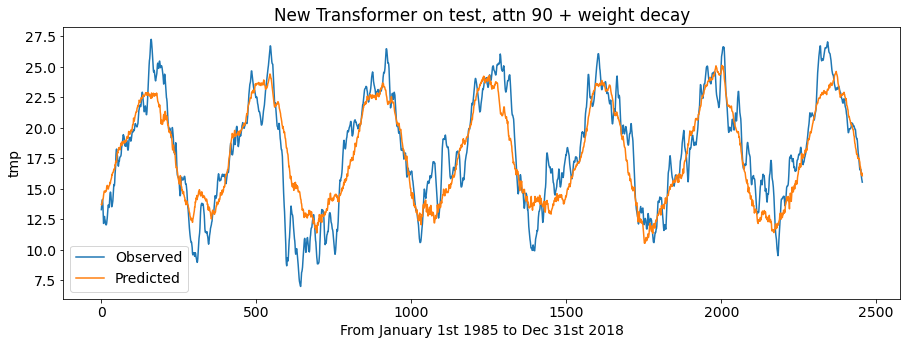

In [65]:
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[-test_size:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer on test, attn 90 + weight decay');

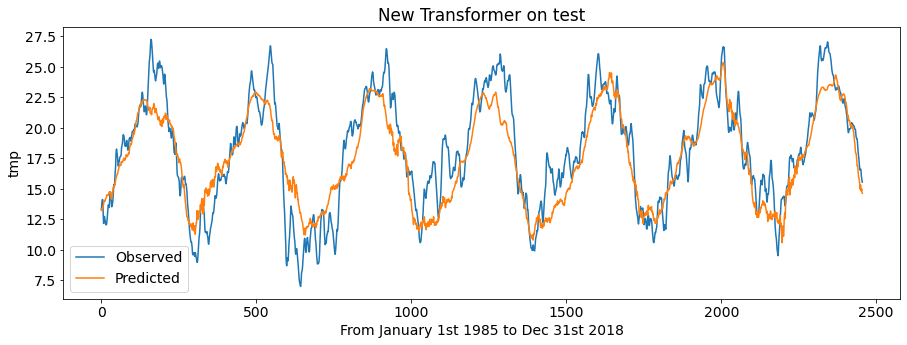

In [57]:
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[-test_size:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('New Transformer on test');

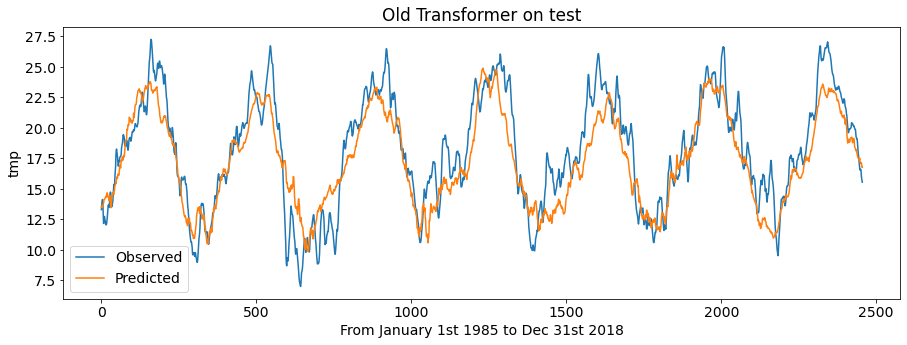

In [49]:
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[-test_size:],label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Old Transformer on test');

In [60]:
res_renorm[train_window:-test_size].shape, res_renorm[-test_size:].shape

((9816,), (2456,))

### Zeros + trend

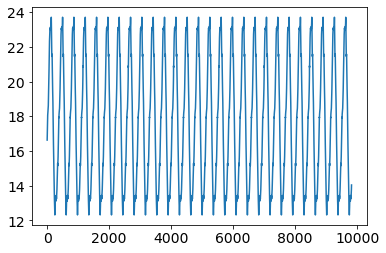

In [58]:
y_train_pred_0, y_test_pred_0 = retrend(np.zeros((9816)), np.zeros((2456)),
        y_total_with_trend[:-28][train_window:-test_size])

plt.plot(retrend(np.zeros((9816)), np.zeros((2456)), 
        y_total_with_trend[:-28][train_window:-test_size])[0])

In [59]:
y_all_with_trend[train_window:-test_size].shape, y_train_pred_0.shape

((9816, 1), (9816, 1))

r-sq on train: 0.8282054790057254
r-sq on test: 0.8074899153585599


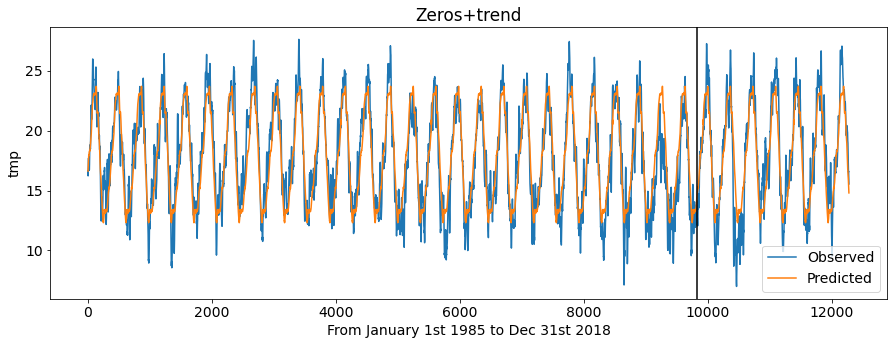

In [60]:
print('r-sq on train:', r2_score(y_all_with_trend[train_window:-test_size], 
                                 y_train_pred_0))
print('r-sq on test:', r2_score(y_all_with_trend[-test_size:],  
                                y_test_pred_0))
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[train_window:],label='Observed')
plt.plot(np.concatenate((y_train_pred_0, y_test_pred_0)),label='Predicted')
# plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend))[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Zeros+trend')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

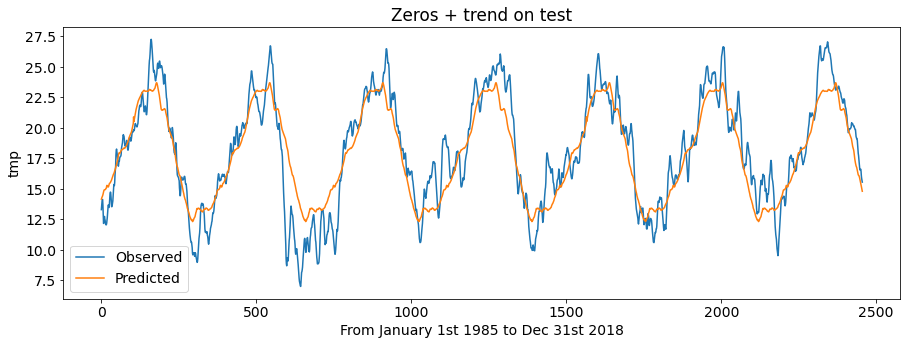

In [61]:
plt.figure(figsize=(15,5))
plt.plot(y_all_with_trend[-test_size:],label='Observed')
plt.plot(np.concatenate((y_train_pred_0, y_test_pred_0))[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Zeros + trend on test');

### XGBoost 

In [62]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
        #print(X.shape, y.shape)
        #self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y) for loc in range(self.num_models))# 197x2x num_estimators



        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [64]:
mdl = XGBoost(num_models=1, n_jobs=1)
mdl.fit(X_train, y_train_detrend)
pred_train = mdl.predict(X_train)
pred_test = mdl.predict(X_test)

[08:22:54] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[08:22:54] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:22:54] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


r-sq on train: 0.4770316522626996
r-sq on test: -0.03322410835642331
cosine_similarity on train: [[0.97504361]]
cosine_similarity on test: [[0.97259845]]


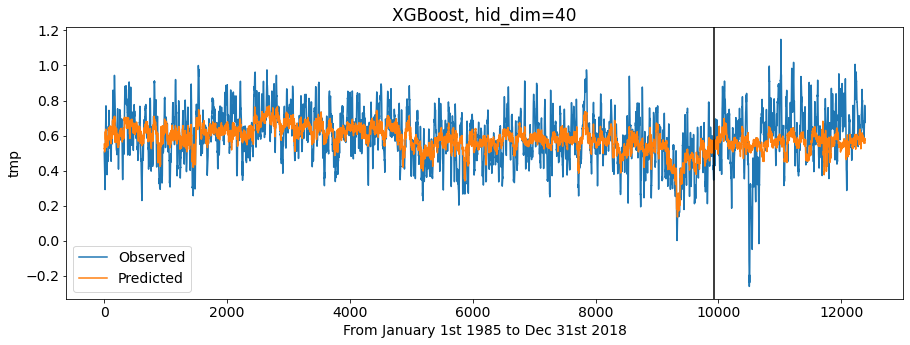

In [68]:
print('r-sq on train:', r2_score(y_train_detrend, pred_train))
print('r-sq on test:', r2_score(y_test_detrend,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train_detrend, y_test_detrend)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=40')
plt.axvline(x=np.concatenate((y_train_detrend, y_test_detrend)).shape[0]- test_size,c='black');

In [67]:
y_train_pred_retrend, y_test_pred_retrend = retrend(pred_train, pred_test,  y_train)

r-sq on train: 0.7861499343863387
r-sq on test: 0.7923582326739874
cosine_similarity on train: [[0.99599978]]
cosine_similarity on test: [[0.99430928]]


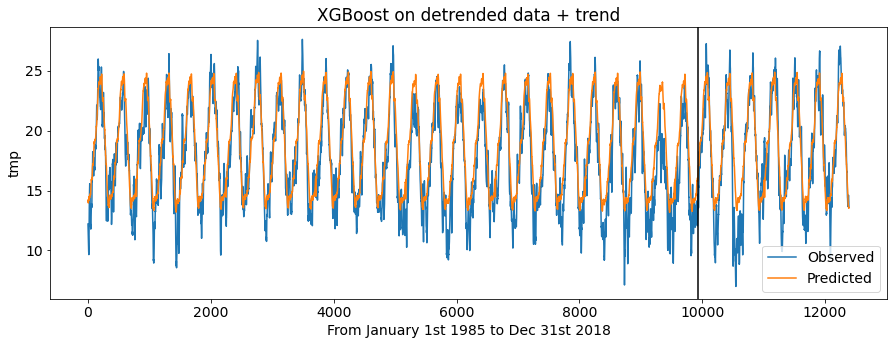

In [72]:
print('r-sq on train:', r2_score(y_train, y_train_pred_retrend))
print('r-sq on test:', r2_score(y_test,  y_test_pred_retrend))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), y_train_pred_retrend.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  y_test_pred_retrend.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((y_train_pred_retrend, y_test_pred_retrend)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on detrended data + trend')
plt.axvline(x=np.concatenate((y_train_detrend, y_test_detrend)).shape[0]- test_size,c='black');

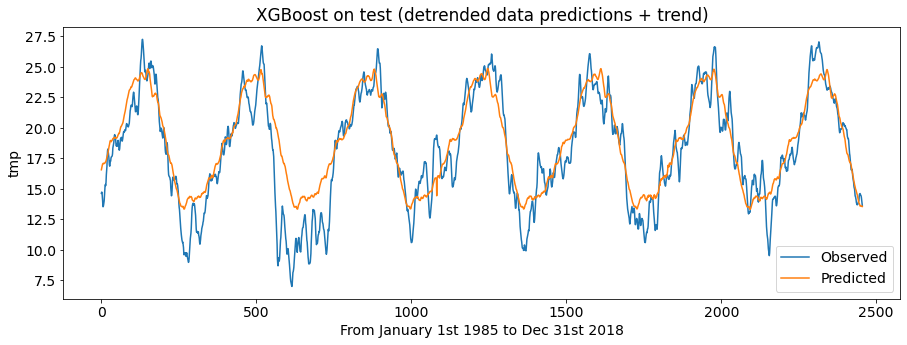

In [74]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(y_test_pred_retrend,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test (detrended data predictions + trend)');